# CellRank beyond RNA velocity

This tutorial shows how to work with CellRank when no <cite data-cite="manno:18">RNA veloctiy</cite> information is available - either because this just isn't available at the moment, or maybe because RNA velocity does not work well in your biological system. RNA velocity is a fantastic method, but like any other method, it has its limitations. To name just one, it relies on having sufficient unspliced counts in the key biological driver genes for your system in order to reliably estimate the direction of cellular dynamics. 

When no RNA velocity information is available, **CellRank can still be used**. You just need to work with a different `kernel` to compute your transition matrix. If you're unsure what a `kernel` is, please go through our [kernels and estimators tutorial](https://cellrank.readthedocs.io/en/stable/kernels_and_estimators.html) first. One possibility to get a directed cell-cell transition matrix is to use a KNN graph and a pseudotime to bias the graph such that edges are likely to point into the direction of increasing pseudotime - this idea has been explored in <cite data-cite="setty:19">Palantir</cite> and is implemented in CellRank via the [PseudotimeKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.tl.kernels.PseudotimeKernel.html). In this tutorial, we'll take a different approach that circumvents the need to define a root cell for pseudotime computation by using the <cite data-cite="gulati:20">CytoTRACE score</cite> to direct graph-edges to point into the direction of increasing differentiation status. In CellRank, this can be achieved using the [CytoTraceKernel](https://cellrank.readthedocs.io/en/stable/api/cellrank.tl.kernels.CytoTRACEKernel.html). We'll give more details on this later on. 

As an example, we'll apply this to the **axial mesoderm lineage of the zebrafish embryo** data generated by <cite data-cite="farrell:18">Farrell et al., Science 2018</cite>. Note that the same subset of this data has been used in Supplementary Fig. 7 of <cite data-cite="nowotschin:19">Nowotschin et al., Nature 2019</cite> to show generalization of their Harmony algorithm. We restricted data from the original study to cells labelled as `Lineage_Prechordal_Plate` and `Lineage_Notochord`.

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/master/tutorials/beyond_rna_velocity.ipynb).

## Import packages and data

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev

In [2]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

The following command will download the `adata` object (43 MB) and save it under `datasets/zebrafish.h5ad`. 

In [3]:
adata = cr.datasets.zebrafish()
adata

100%|██████████| 41.3M/41.3M [00:01<00:00, 29.0MB/s]


AnnData object with n_obs × n_vars = 2434 × 23974
    obs: 'Stage', 'gt_terminal_states', 'lineages'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors'
    obsm: 'X_force_directed'

This is a scRNA-seq time-series dataset of zebrafish embryogenesis assayed using drop-seq, restricted to the axial mesoderm lineage. It contains 12 time-points spanning 3.3 - 12 hours past fertilization. We can use the original force-directed layout to plot cells, colored by developmental stage:

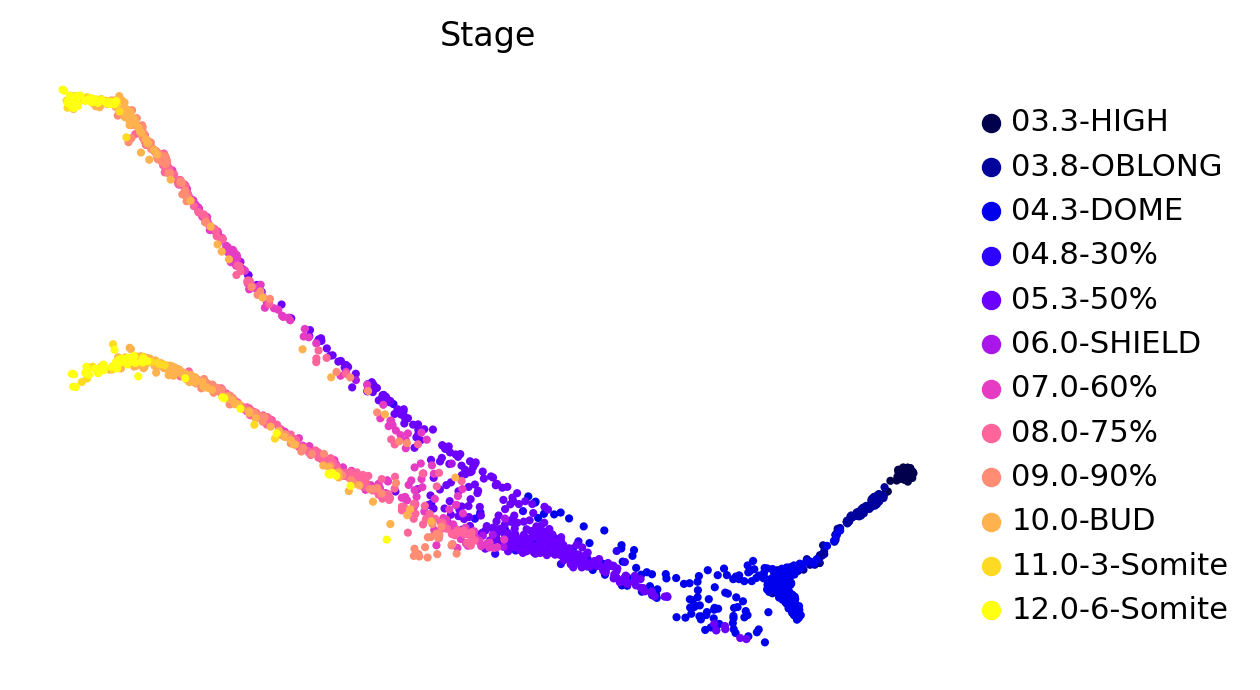

In [4]:
scv.pl.scatter(adata, basis="force_directed", c="Stage", legend_loc="right")

We can further look into the lineage assignments, computed in the original study using URD: 

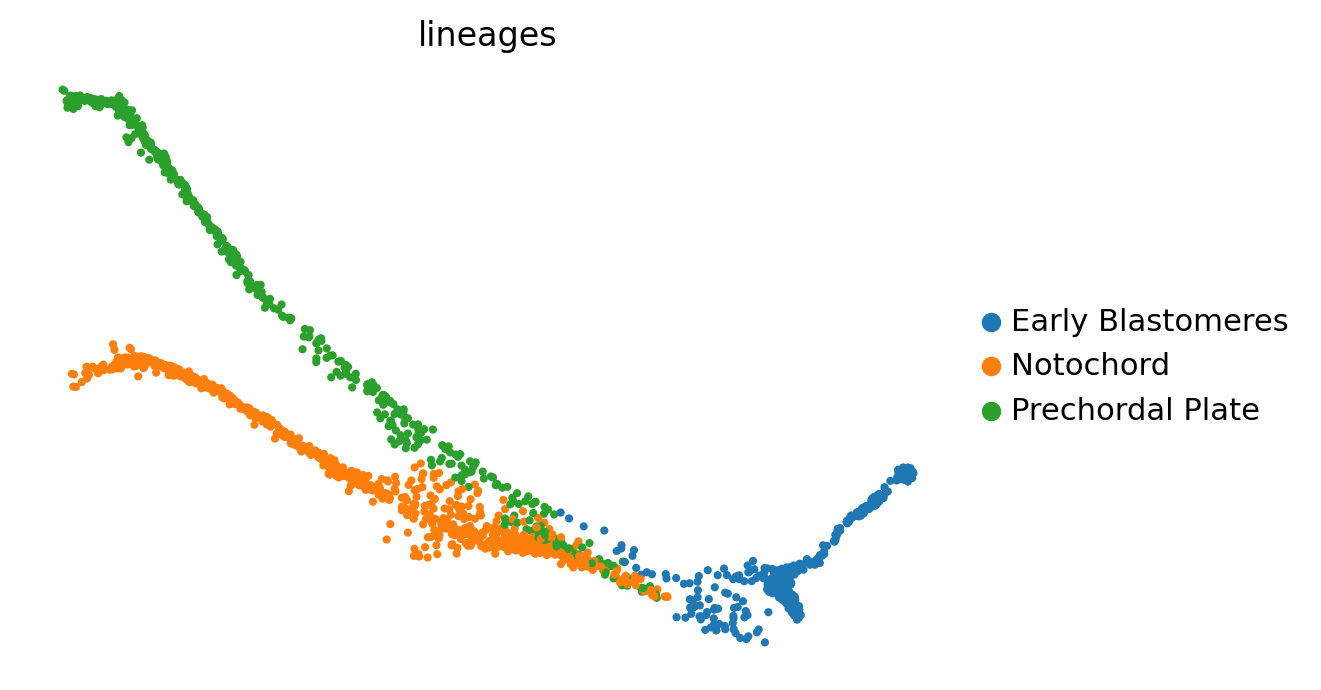

In [5]:
scv.pl.scatter(adata, basis="force_directed", c="lineages", legend_loc="right")

## Pre-process the data

Before we can start applying the CytoTRACE kernel, we'll have to do some basic pre-processing of the data. 

In [6]:
# filter, normalize total counts and log-transform
sc.pp.filter_genes(adata, min_cells=10)
scv.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# hvg annotation
sc.pp.highly_variable_genes(adata)
print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")

# use scVelo's `moments` function for imputation - note that hack we're using here:
# we're copying our `.X` matrix into the layers because that's where `scv.tl.moments`
# expects to find counts for imputation
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Normalized count data: X.
This detected 2392 highly variable genes. 
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Initialize the CytoTRACE kernel

Import the kernel and initialize it using the pre-processed AnnData object:

In [7]:
from cellrank.tl.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(adata)

Computing CytoTRACE score with `13690` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


Upon initialization of the kernel, two things are computed, the actual CytoTRACE score (`adata.obs['ct_score']`) as well as a pseudotime (`adata.obs['ct_pseudotime']`) which is simply one minus the score.

Note that this is a re-implementation of the original CytoTRACE algorithm which scales better to large sample sizes because we changed the way in which gene counts are imputed. This will **not** exactly reproduce the original results. However, we checked in a subset of datasets from the <cite data-cite="gulati:20">original study</cite> that our re-implementation performs at least as good as the original implementation in terms of Spearman correlation with ground truth annotations, i.e. in capturing ground-truth differentiation status. 

We can visually check that our computed CytoTRACE pseudotime correlates well with ground-truth real-time annotations:

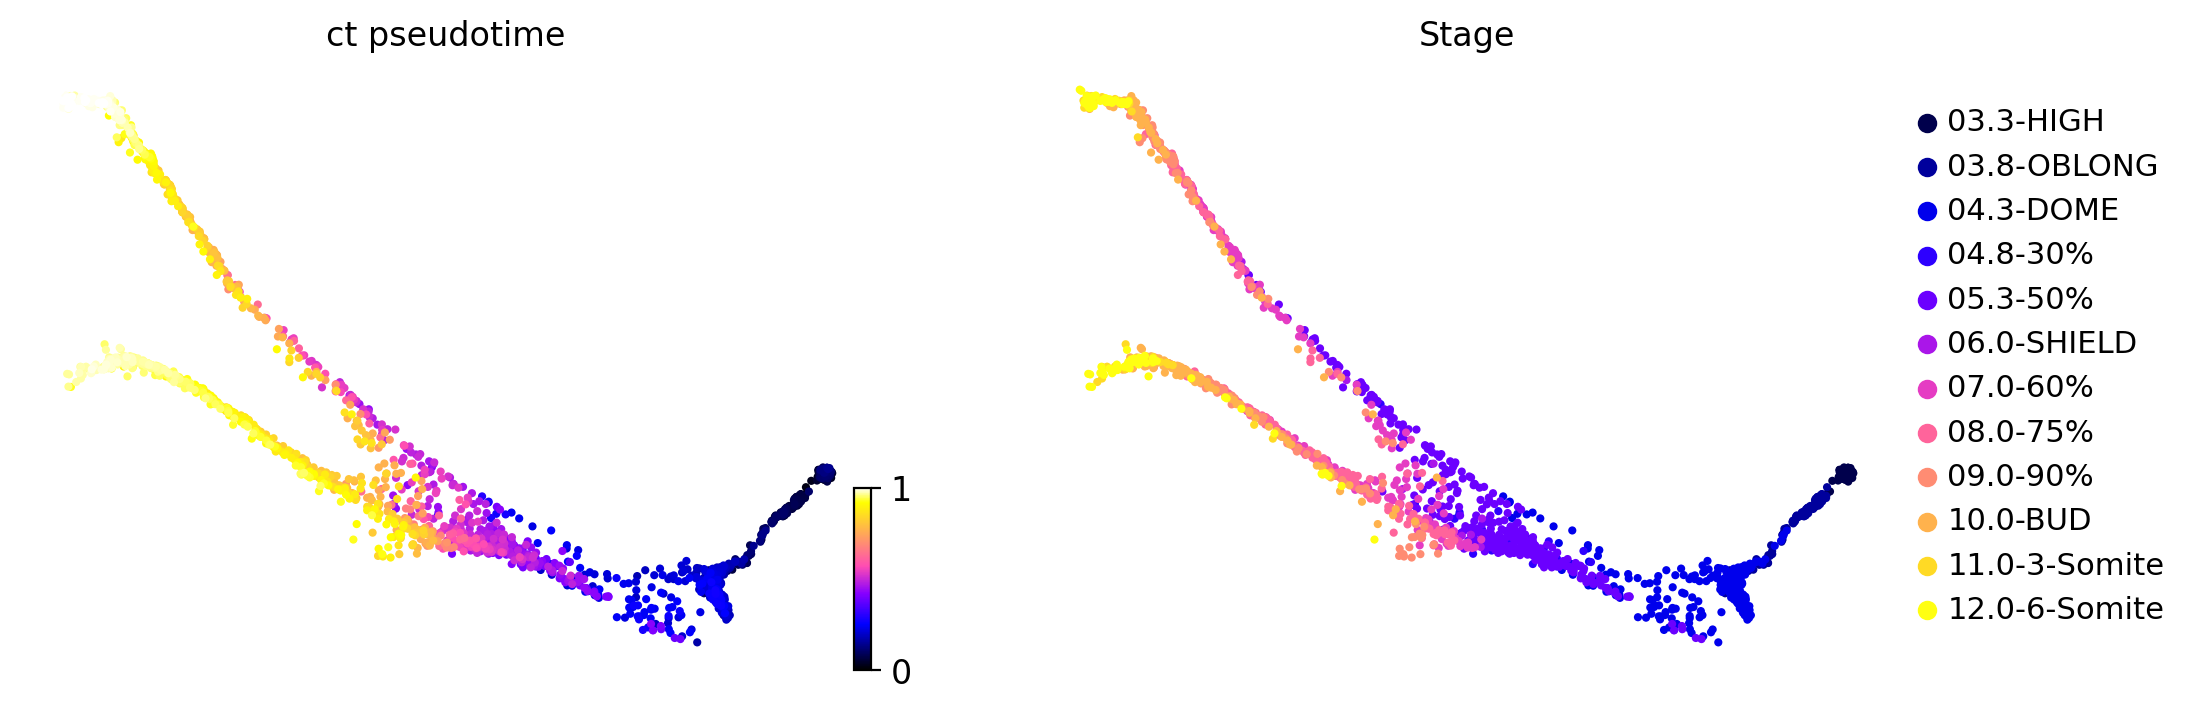

In [8]:
scv.pl.scatter(
    adata,
    c=["ct_pseudotime", "Stage"],
    basis="force_directed",
    legend_loc="right",
    color_map="gnuplot2",
)

To make this a bit more quantitative, we can look at the distribution of our pseudotime over real-time-points and show this via violin plots:

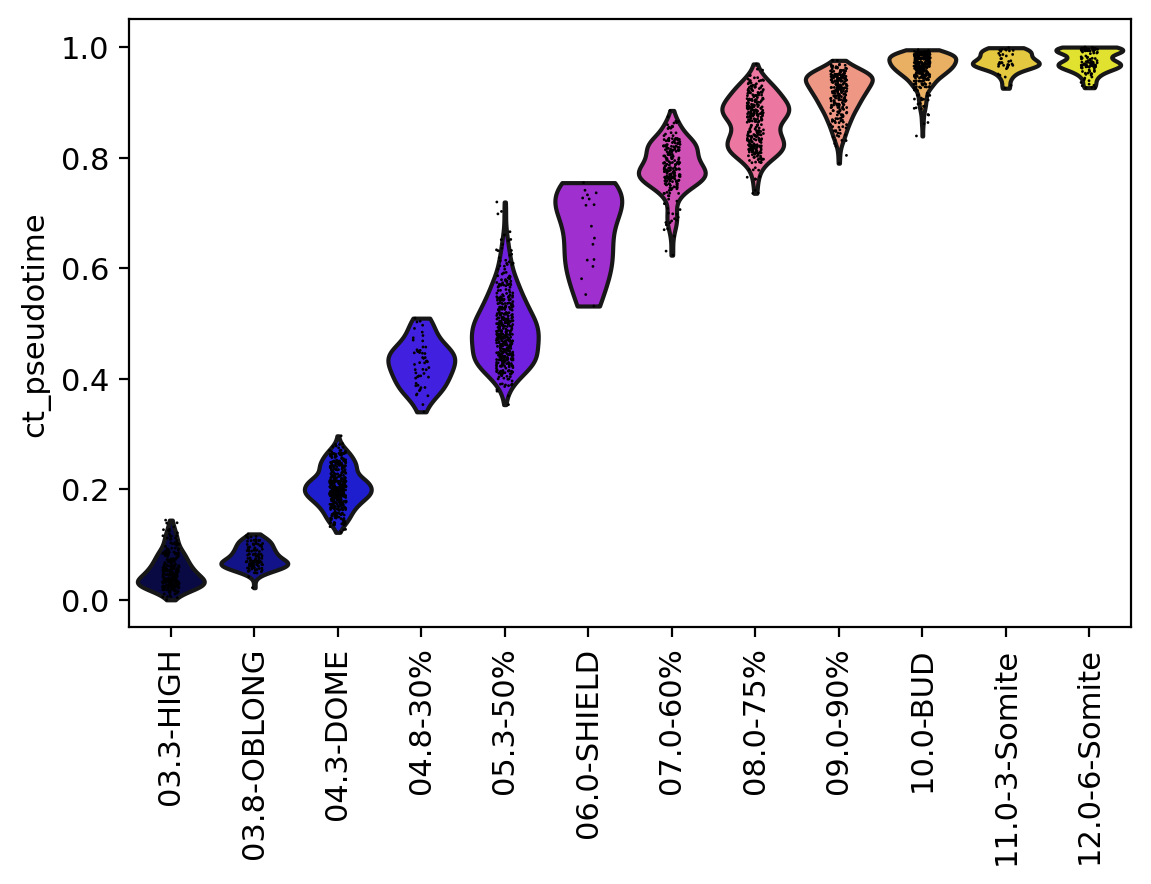

In [9]:
sc.pl.violin(adata, keys=["ct_pseudotime"], groupby="Stage", rotation=90)

The CytoTRACE pseudotime can thus be used to bias graph edges into the direction of increasing differentiation status. 

## Compute & visualize a transition matrix

First thing we need to do is to actually compute the transition matrix:

In [10]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)

Computing transition matrix based on `ct_pseudotime`
    Finish (0:00:01)


100%|██████████| 2434/2434 [00:00<00:00, 2624.31cell/s]


<CytoTRACEKernel>

Under the hood, this feeds the computed CytoTRACE pseudotime into a `PseudotimeKernel` - our general class for taking a KNN graph and a pseudotime to compute a biased KNN graph whose edges are likely to point into the direction of increasing pseudotime. This kernel essentially combines and adapts ideas from <cite data-cite="setty:19">Palantir</cite> (choose `threshold_scheme='hard'`) and <cite data-cite="stassen:21">VIA</cite> (choose `threshold_scheme='soft'`). 

To get some intuition for this transition matrix, we can project it into an embedding and draw the same sort of arrows that we all got used to from RNA velocity - the following plot will look **exactly** like the plots you're used to from scVelo for visualizing RNA velocity, however, there's **no RNA velocity** here (feel free to inspect the AnnData object closely), we're visualizing the directed transition matrix we computed using the KNN graph as well as the CytoTRACE pseudotime. 

Projecting transition matrix onto `force_directed`
Adding `adata.obsm['T_fwd_force_directed']`
    Finish (0:00:00)


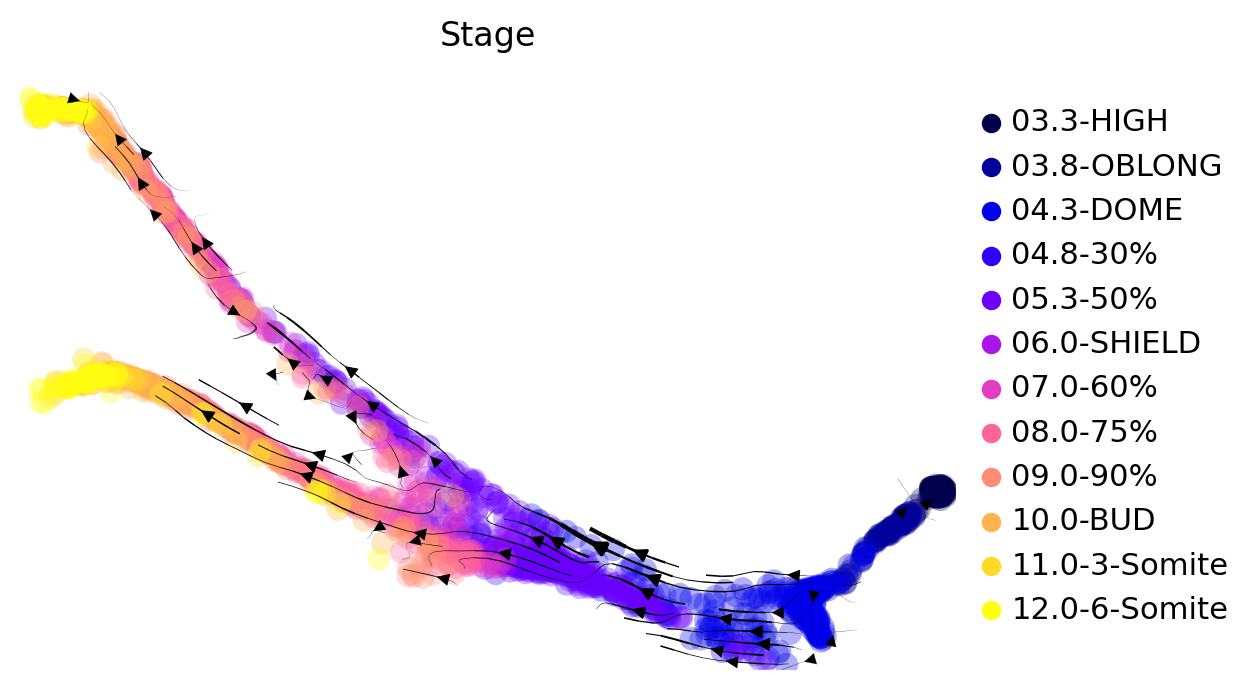

In [11]:
ctk.compute_projection(basis="force_directed")
scv.pl.velocity_embedding_stream(
    adata, color="Stage", vkey="T_fwd", basis="force_directed", legend_loc="right"
)

The process of differentiation seems to be captured well by this transition matrix. We can visually confirm this by looking at terminal-state annotations from the original study: 

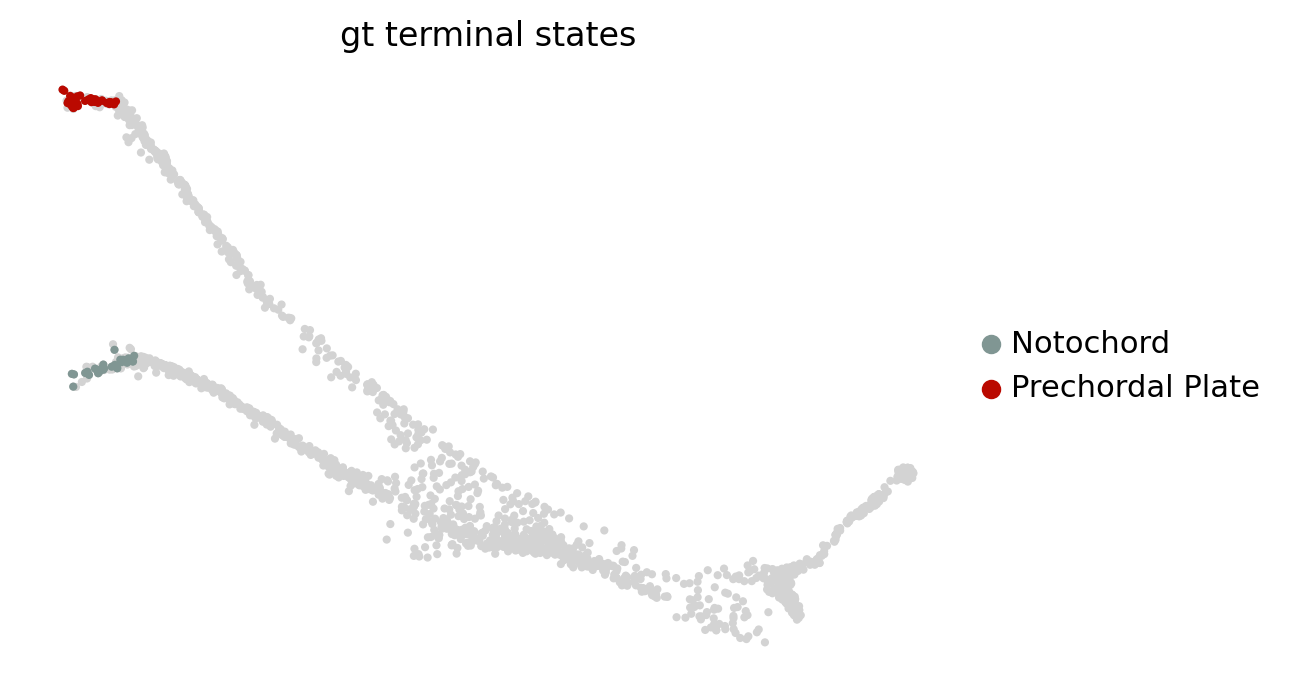

In [12]:
scv.pl.scatter(
    adata, basis="force_directed", c="gt_terminal_states", legend_loc="right"
)

Another way to gain intuition for the transition matrix is by drawing some cells from the early stage and to use these as starting cells to simulate random walks on the transition matrix:

Simulating `15` random walks of maximum length `609`
    Finish (0:00:01)
Plotting random walks


100%|██████████| 15/15 [00:01<00:00, 10.98sim/s]


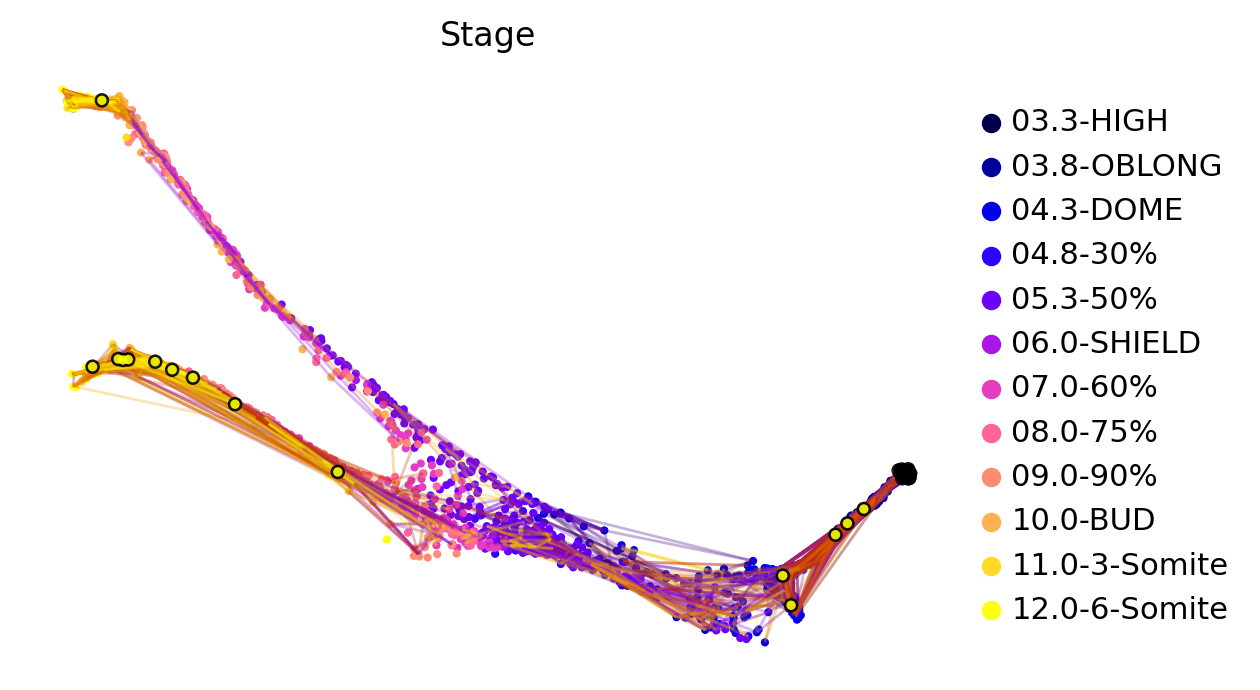

In [13]:
ctk.plot_random_walks(
    n_sims=15,
    start_ixs={"Stage": "03.3-HIGH"},
    basis="force_directed",
    color="Stage",
    legend_loc="right",
    seed=1,
)

Black dots denote sampled starting cells for random walks, yellow dots denote end cells. We terminated each random walk after a predefined number of steps. Random walks are colored according to how long they've been running for - i.e. the initial segments are more black/blue whereas the late segments are more orange/yellow. 

We can see that most random walks terminate in one of the two terminal states, as expected. However, it also appears you can get "stuck" in the beginning, around the `03.8-OBLONG` stage. We'll investigate this further using macrostates. 

One thing to note: the visualization techniques demonstrated here work for **every kernel**, no matter whether it's a `VelocityKernel`, `PseudotimeKernel`, `CytoTRACEKernel` or some future kernel. 

## Compute macrostates

To compute macrostates, and fate probabilities towards a subset of them, we'll use an estimator object:

In [14]:
from cellrank.tl.estimators import GPCCA

g_fwd = GPCCA(ctk)
print(g_fwd)

GPCCA[n=2434, kernel=<CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.5]>]


As always, we'll compute a Schur decomposition and use that to define our macrostates:

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:08)


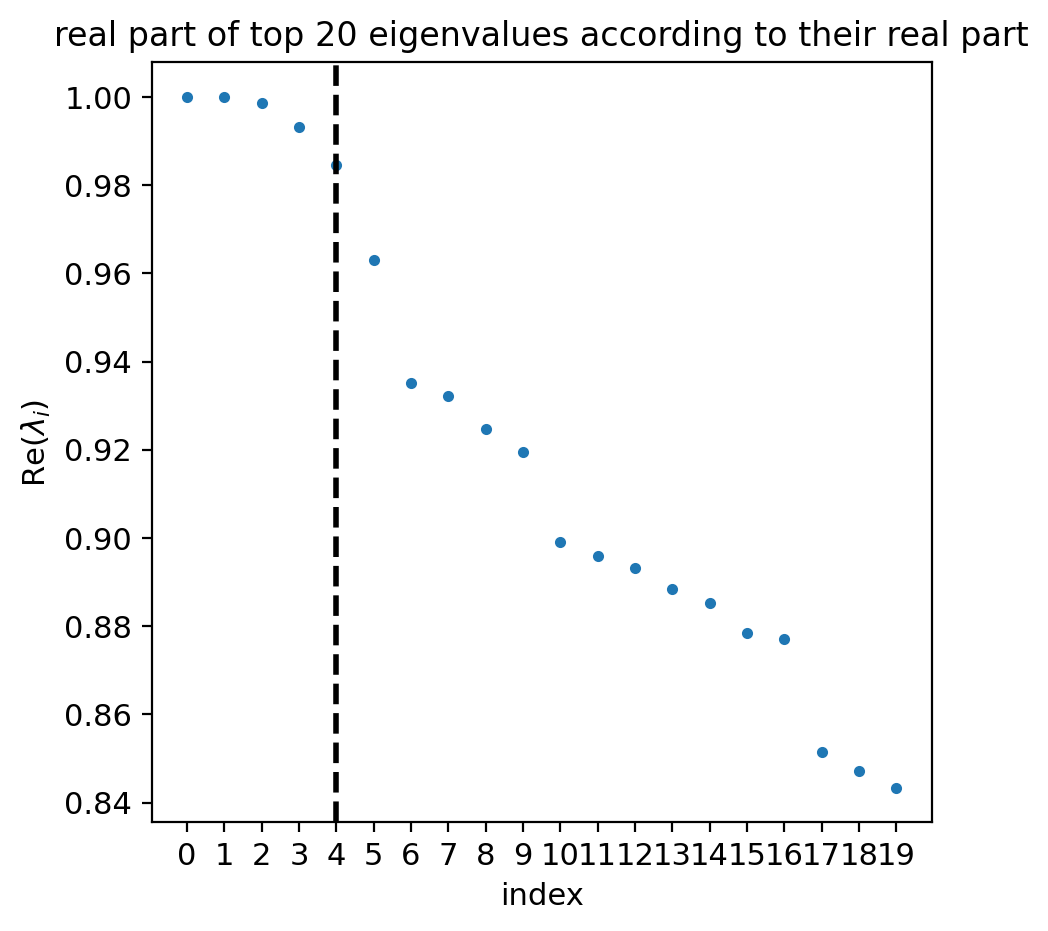

In [15]:
g_fwd.compute_schur(n_components=20)
g_fwd.plot_spectrum(real_only=True)

CellRank automatically identified an 'eigengap' after three eigenvalues (dashed line above), so we'll compute three macrostates:

Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


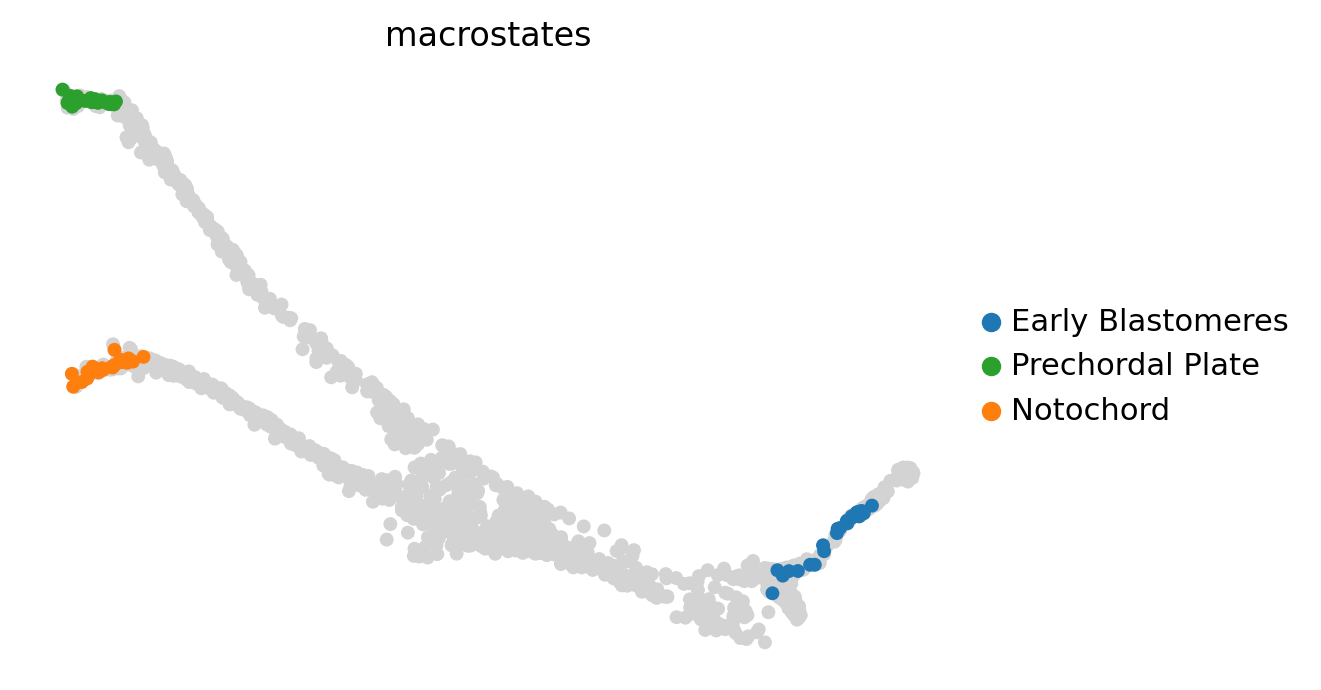

In [16]:
g_fwd.compute_macrostates(n_states=3, cluster_key="lineages")
g_fwd.plot_macrostates(
    discrete=True, legend_loc="right", size=100, basis="force_directed"
)

We identified three macrostates - two corresponding to the terminal states and one corresponding to the set of cells where some random walks appeared to get stuck. We can learn a bit more by associating macrostates with the `Stage` label, that's done via the `cluster_key` parameter in `g_fwd.compute_macrostates`. Note that this has **no** effect on the macrostates themselves, it just gives them a different name:

Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)


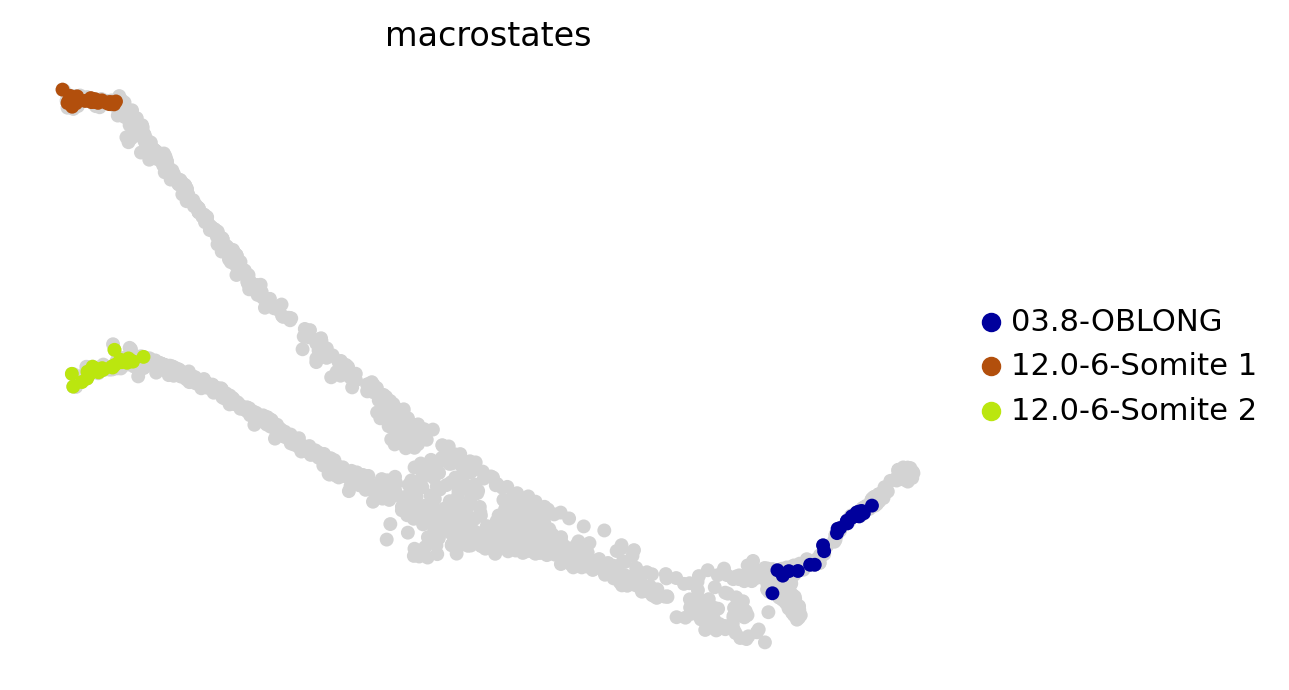

In [17]:
g_fwd.compute_macrostates(n_states=3, cluster_key="Stage")
g_fwd.plot_macrostates(
    discrete=True, legend_loc="right", size=100, basis="force_directed"
)

As expected, two of our macrostates come from the very late stages, whereas one is from the `03.8-OBLONG` stage. We can only speculate why we get a stable early state here: there may be a "gap" in the phenotypic manifold here because early development is very rapid, or maybe there really is some pause before cells commit to either lineage. 

In any case, we can confirm that the early state is very stable by looking at coarse transition probabilities among macrostates:

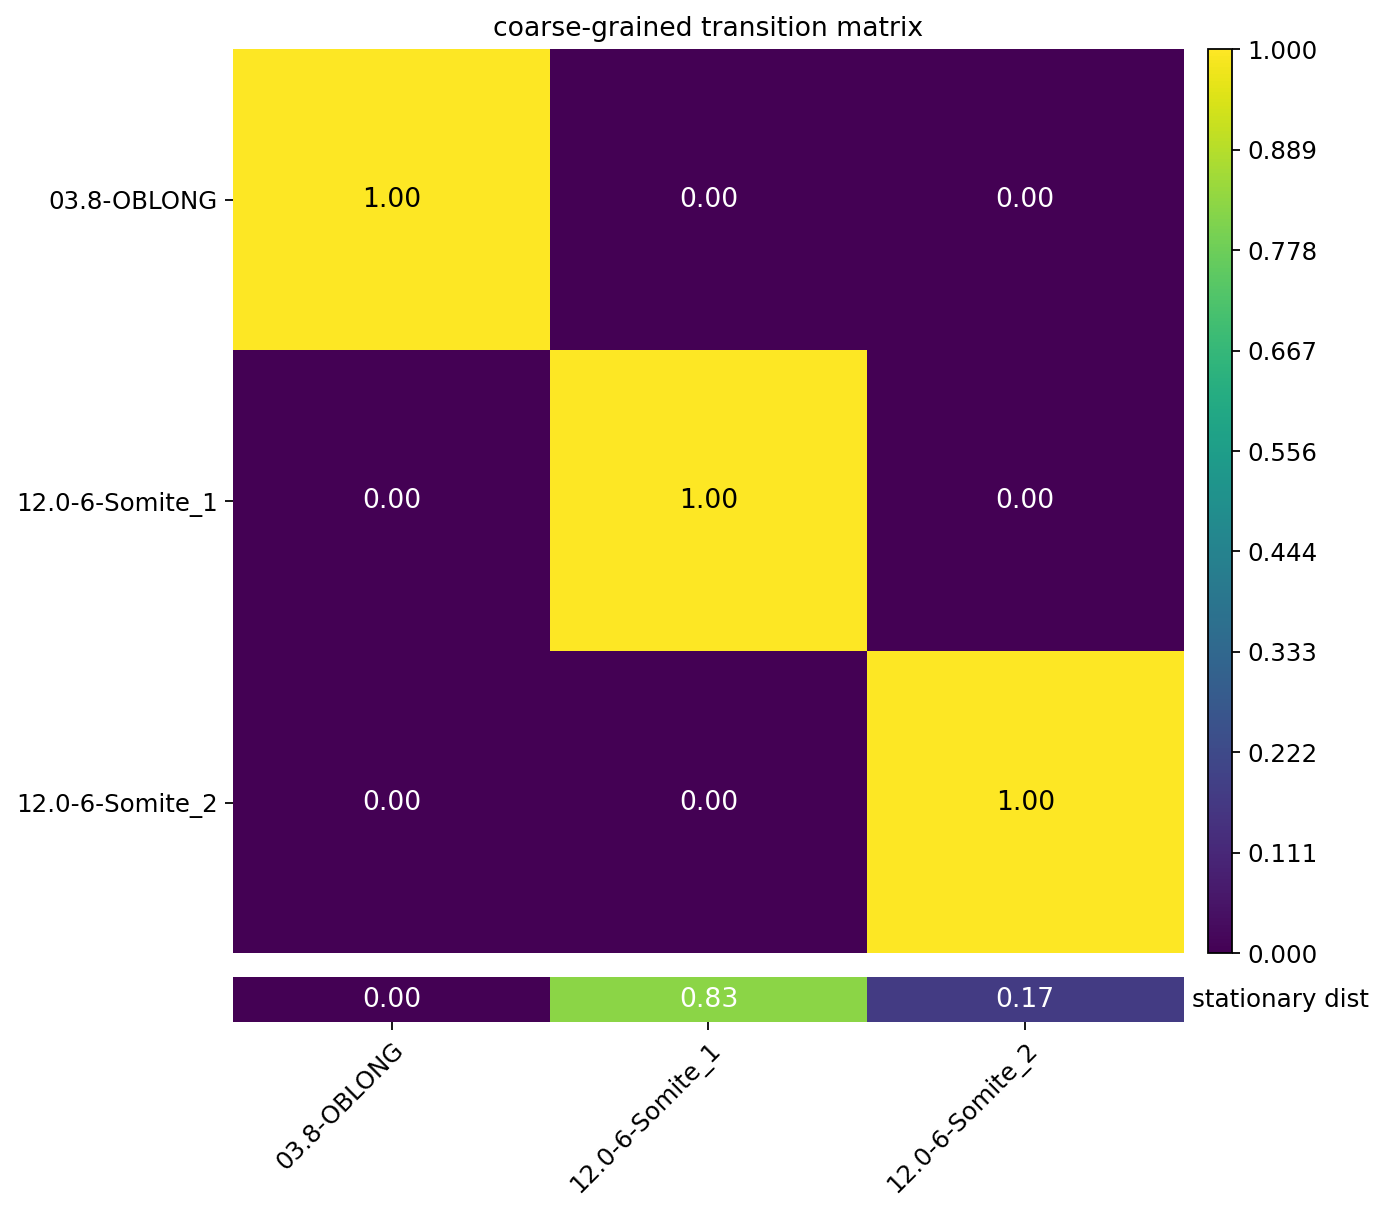

In [18]:
g_fwd.plot_coarse_T()

While all of them are really stable (1 on the diagonal), the `03.8-OBLONG` stage has the smallest value in the coarse-grained stationary distribution, identifying this state as an early state. 

Before we restrict terminal states to the two other states, we will first run `g_fwd.compute_macrostates` again, this time associating it with the `lineages` label, just to get some nicer names for the states:

In [19]:
g_fwd.compute_macrostates(n_states=3, cluster_key="lineages")
g_fwd.set_terminal_states_from_macrostates(names=["Prechordal Plate", "Notochord"])

Computing `3` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


## Compute fate probabilities

Having defined the terminal states, this puts us into a position to compute fate probabilities towards them:

Computing absorption probabilities
Defaulting to `'gmres'` solver.
Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


100%|██████████| 2/2 [00:00<00:00, 16.94/s]


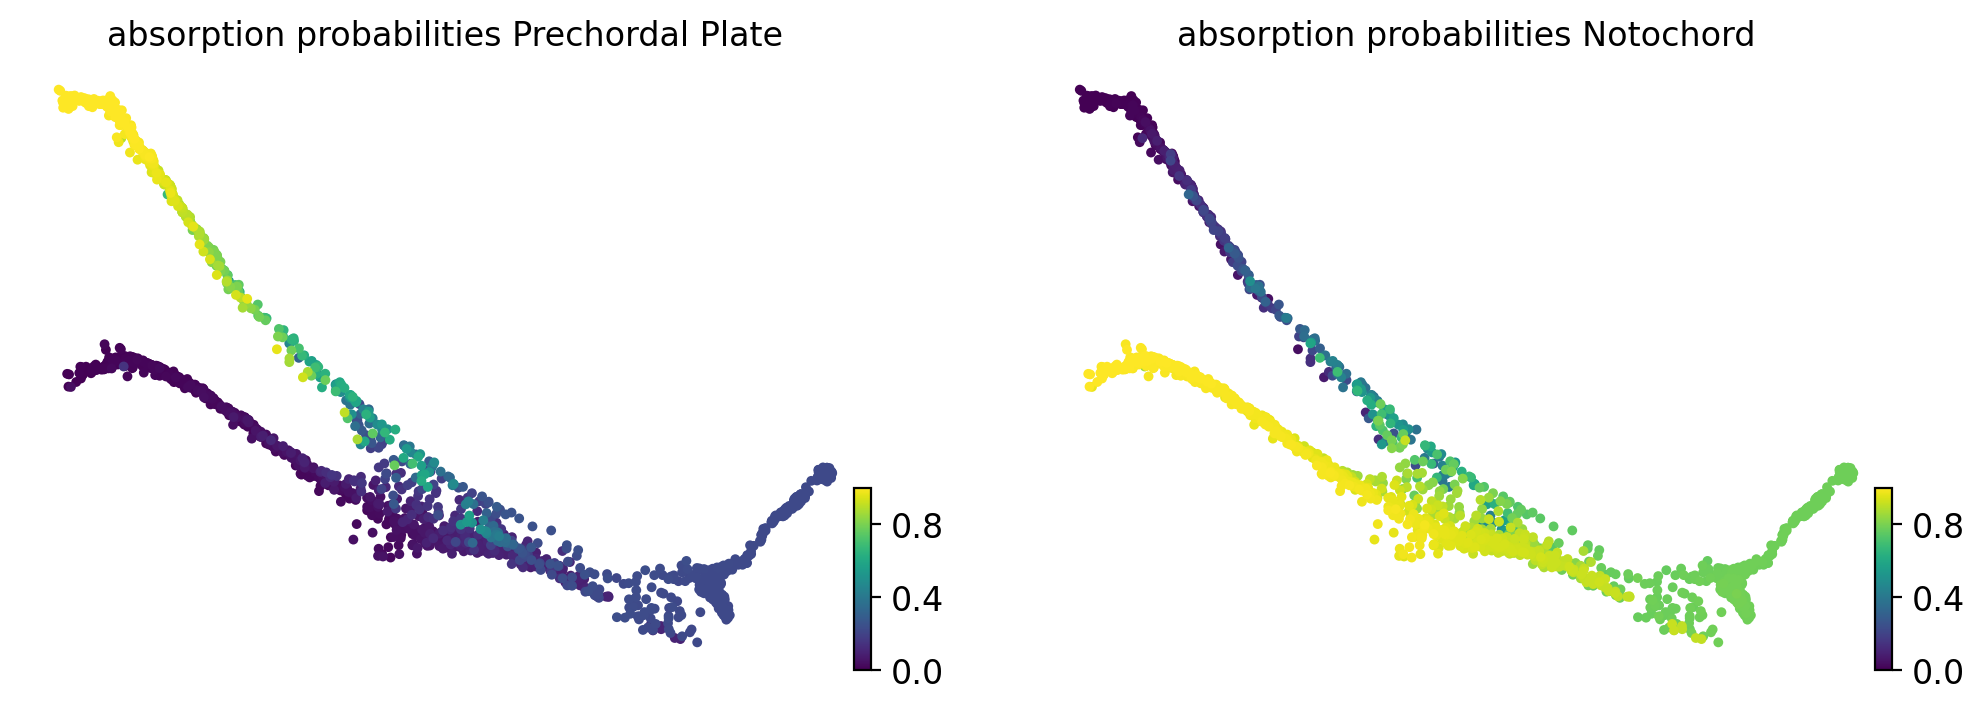

In [20]:
g_fwd.compute_absorption_probabilities()
g_fwd.plot_absorption_probabilities(same_plot=False, size=50, basis="force_directed")

We can visually compare this to the ground-truth lineage labels from the original study:

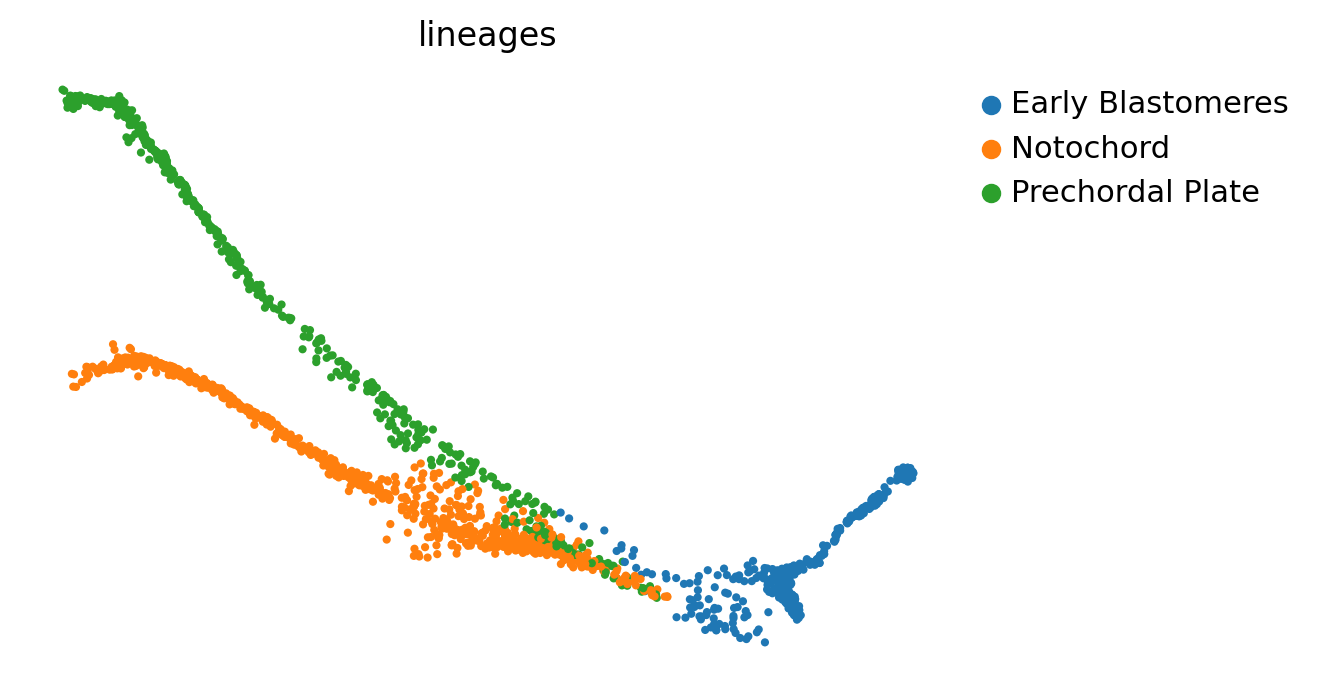

In [21]:
scv.pl.scatter(adata, basis="force_directed", c="lineages")

Now that we have the fate probabilities, we could go into driver genes, gene expression trends, etc. again, just like we did in the other tutorials. However, we'll skip this here to focus on the **key takeaways**:

- CellRank can be used **without RNA velocity**, we just need to compute a transition matrix using e.g. the `Pseudotime` or `CytoTRACEKernel`.
- which kernel to use **depends on your biological system**, if RNA velocity works well you can use that, if not, see whether you can get a good pseudotime using any pseudotime algorithm and feed that into the `PseudotimeKernel`. If you don't have a good pseudotime, maybe because the root cell is unclear, try the `CytoTRACEKernel`. 
- every `kernel` object can visualize its transition matrix though scVelo-like arrows in an embedding, or though a set of simulated random walks.
- every `estimator` works with every `kernel`.

## What's next?

- try this out on your own data. Open an [issue](https://github.com/theislab/cellrank/issues/new/choose) if something is unclear or does not work for you.
- if your data has time-points, check out our [real-time tutorial](https://cellrank.readthedocs.io/en/stable/real_time.html). This interfaces with <cite data-cite="schiebinger:19">Waddington OT</cite> and doesn't need RNA velocity information. 
- we welcome any contributions to CellRank. Please check out our [contributing guide](https://github.com/theislab/cellrank/blob/master/CONTRIBUTING.rst).
- in particular, if you have a method that computes a transition matrix from single-cell data in a way not yet covered by CellRank, consider providing an interface to your method by writing a `kernel` class. It is very simple and we explain it in our [kernel writing tutorial](https://cellrank.readthedocs.io/en/stable/creating_new_kernel.html). 